In [1]:
import torch
import random
from PIL import Image
import os
from torchvision.datasets import CIFAR10, CIFAR100, CocoCaptions, ImageNet
import slip_models
from tokenizer import SimpleTokenizer

import torchvision.transforms as T


In [2]:
# %pip install ipywidgets
# %pip install update tqdm


In [3]:
preprocess = T.Compose(
                    [
                        T.Resize(224),
                        T.CenterCrop(224),
                        T.ToTensor(),
                        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                    ]
                        )

In [12]:
# model = slip_models.CLIP_VITB16(embed_dim=8)
# ckpt = torch.load('ckpts/clip_embed_dim_8_epoch_35.ckpt', map_location='cpu')

model = slip_models.ParallelMultiBinaryCLIP(64)
ckpt = torch.load('tmp_save/test_epoch_1.ckpt', map_location='cpu')

# model = slip_models.CLIP_VITB16(num_prompt_tokens=64, num_text_outputs=1000)
# ckpt = torch.load('ckpts/epoch_30_prompted_clip_may_27.ckpt', map_location='cpu')


model.load_state_dict({k.replace('module.',''):v for k,v in ckpt["model"].items()})
model = model.cuda()

In [13]:
tokenizer = SimpleTokenizer()

In [14]:
# image = preprocess(Image.open("pics/golden-retriever.png")).unsqueeze(0).to(device)
# image = preprocess(Image.open("pics/CLIP.png")).unsqueeze(0).to(device)
base_text = ["a diagram", "a dog", "a cat"]
model.eval()
dog_image = preprocess(Image.open("pics/golden-retriever.png"))
diagram_image = preprocess(Image.open("pics/CLIP.png").convert("RGB"))
cat_image = preprocess(Image.open("pics/cat.jpg"))
images = torch.stack([diagram_image, dog_image, cat_image]).cuda()

text = tokenizer([f"a picture of {s}" for s in base_text]).cuda()

with torch.no_grad():
    image_features = model.encode_image(images)
    text_features = model.encode_text(text)
    
    logits_per_image = model.logit_scale.exp() * image_features @ text_features.t()
    # logits_per_image, logits_per_text = model(images, text)
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()

print("Label probs:", probs)  # prints: [[0.9927937  0.00421068 0.00299572]]

Label probs: [[0.33333334 0.33333334 0.33333334]
 [0.33333334 0.33333334 0.33333334]
 [0.33333334 0.33333334 0.33333334]]


In [15]:
# Download the dataset
cifar10 = CIFAR10(root="/tmp/", transform=preprocess, download=True, train=False)
loader = torch.utils.data.DataLoader(cifar10, batch_size=10, shuffle=True)
# text_inputs = torch.stack([tokenizer(f"a photo of a {c}") for c in cifar10.classes]).cuda()


text_inputs = torch.stack([tokenizer(f"a photo of a {c}") for c in cifar10.classes]).cuda()


num_correct = 0
num_seen = 0
with torch.no_grad():
    #  text_features = model.encode_text(text_inputs)
    for imgs, targets in loader:
        imgs = imgs.cuda()
        targets = targets.cuda()
        
        # image_features = model.encode_image(imgs)
        # results = model(imgs, text_inputs, lang_prompt_viz=True, sharded_computation=False)
        results = model(imgs, text_inputs)
        image_features = results['image_embed']
        image_features = image_features / image_features.norm(dim=1, keepdim=True)

        text_features = results['text_embed']
        text_features = text_features / text_features.norm(dim=1, keepdim=True)
        
        similarity = (image_features @ text_features.T).softmax(dim=-1)
        max_sims = similarity.max(dim=-1)[0]
        print(max_sims.min(), max_sims.max(), max_sims.mean())
        num_correct += (similarity.argmax(dim=-1)==targets).sum().item()  
        num_seen += imgs.shape[0]
        curr_acc = num_correct / num_seen
        print(f"Current Acc: {curr_acc}")
acc = num_correct / len(cifar10)
print(f"Final Acc {acc}")

Files already downloaded and verified
tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0')
Current Acc: 0.3
tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0')
Current Acc: 0.2
tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0')
Current Acc: 0.23333333333333334
tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0')
Current Acc: 0.175
tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0')
Current Acc: 0.14
tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0')
Current Acc: 0.13333333333333333
tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0')
Current Acc: 0.14285714285714285
tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0')
Current Acc: 0.1375
tens

tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0')
Current Acc: 0.10149253731343283
tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0')
Current Acc: 0.10441176470588236
tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0')
Current Acc: 0.10579710144927536
tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0')
Current Acc: 0.11
tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0')
Current Acc: 0.11126760563380282
tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0')
Current Acc: 0.10972222222222222
tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0')
Current Acc: 0.1136986301369863
tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0')
Current Acc: 0.11

tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0')
Current Acc: 0.10606060606060606
tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0')
Current Acc: 0.10751879699248121
tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0')
Current Acc: 0.10746268656716418
tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0')
Current Acc: 0.10666666666666667
tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0')
Current Acc: 0.10661764705882353
tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0')
Current Acc: 0.10656934306569343
tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0')
Current Acc: 0.1072463768115942
tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0')
Cu

tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0')
Current Acc: 0.1086734693877551
tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0')
Current Acc: 0.10862944162436548
tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0')
Current Acc: 0.10909090909090909
tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0')
Current Acc: 0.10954773869346733
tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0')
Current Acc: 0.1095
tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0')
Current Acc: 0.10945273631840796
tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0')
Current Acc: 0.1099009900990099
tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0')
Current Acc: 0.1

tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0')
Current Acc: 0.10576923076923077
tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0')
Current Acc: 0.1053639846743295
tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0')
Current Acc: 0.1049618320610687
tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0')
Current Acc: 0.10456273764258556
tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0')
Current Acc: 0.1053030303030303
tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0')
Current Acc: 0.10528301886792453
tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0')
Current Acc: 0.10563909774436091
tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0')
Curr

tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0')
Current Acc: 0.10679012345679012
tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0')
Current Acc: 0.10646153846153845
tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0')
Current Acc: 0.10613496932515337
tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0')
Current Acc: 0.10642201834862386
tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0')
Current Acc: 0.10670731707317073
tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0')
Current Acc: 0.10699088145896657
tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0')
Current Acc: 0.10666666666666667
tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0')
C

tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0')
Current Acc: 0.10592783505154639
tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0')
Current Acc: 0.10565552699228792
tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0')
Current Acc: 0.10538461538461538
tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0')
Current Acc: 0.10562659846547315
tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0')
Current Acc: 0.10561224489795919
tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0')
Current Acc: 0.10559796437659033
tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0')
Current Acc: 0.10532994923857868
tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0')
C

tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0')
Current Acc: 0.10265486725663717
tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0')
Current Acc: 0.10242825607064018
tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0')
Current Acc: 0.1026431718061674
tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0')
Current Acc: 0.10241758241758242
tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0')
Current Acc: 0.10285087719298246
tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0')
Current Acc: 0.10306345733041576
tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0')
Current Acc: 0.10305676855895196
tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0')
Cu

tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0')
Current Acc: 0.10251937984496123
tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0')
Current Acc: 0.102321083172147
tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0')
Current Acc: 0.10212355212355212
tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0')
Current Acc: 0.10192678227360308
tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0')
Current Acc: 0.10230769230769231
tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0')
Current Acc: 0.10211132437619962
tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0')
Current Acc: 0.1021072796934866
tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0')
Curr

tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0')
Current Acc: 0.10051724137931034
tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0')
Current Acc: 0.10034423407917384
tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0')
Current Acc: 0.10034364261168385
tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0')
Current Acc: 0.10034305317324185
tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0')
Current Acc: 0.10034246575342466
tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0')
Current Acc: 0.10034188034188034
tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0')
Current Acc: 0.10051194539249146
tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0')
C

tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0')
Current Acc: 0.10124223602484472
tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0')
Current Acc: 0.10124031007751938
tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0')
Current Acc: 0.10108359133126935
tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0')
Current Acc: 0.10092735703245749
tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0')
Current Acc: 0.1007716049382716
tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0')
Current Acc: 0.10077041602465331
tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0')
Current Acc: 0.10092307692307692
tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0')
Cu

tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0')
Current Acc: 0.09971751412429379
tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0')
Current Acc: 0.0998589562764457
tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0')
Current Acc: 0.09971830985915493
tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0')
Current Acc: 0.09971870604781997
tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0')
Current Acc: 0.0997191011235955
tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0')
Current Acc: 0.1
tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0')
Current Acc: 0.10014005602240897
tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0')
Current Acc: 0.1
te

tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0')
Current Acc: 0.10012953367875647
tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0')
Current Acc: 0.1
tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0')
Current Acc: 0.1
tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0')
Current Acc: 0.09987096774193549
tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0')
Current Acc: 0.1
tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0')
Current Acc: 0.1
tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0')
Current Acc: 0.10012853470437018
tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0')
Current Acc: 0.1
tensor(0.1000, device='cuda:0') tensor(0.1000, d

tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0')
Current Acc: 0.1015531660692951
tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0')
Current Acc: 0.10155131264916467
tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0')
Current Acc: 0.10154946364719905
tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0')
Current Acc: 0.10166666666666667
tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0')
Current Acc: 0.10154577883472057
tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0')
Current Acc: 0.10142517814726841
tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0')
Current Acc: 0.10130486358244366
tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0')
Cu

tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0')
Current Acc: 0.10099889012208657
tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0')
Current Acc: 0.10110864745011086
tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0')
Current Acc: 0.1009966777408638
tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0')
Current Acc: 0.10088495575221239
tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0')
Current Acc: 0.10077348066298343
tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0')
Current Acc: 0.10088300220750551
tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0')
Current Acc: 0.10077177508269018
tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0')
Cu

tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0')
Current Acc: 0.10072538860103628
tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0')
Current Acc: 0.10062111801242236
tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0')
Current Acc: 0.10051706308169597
tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0')
Current Acc: 0.10051652892561984
tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0')
Current Acc: 0.10061919504643962
tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0')
Current Acc: 0.10051546391752578
tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0')
Current Acc: 0.1004119464469619
tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0') tensor(0.1000, device='cuda:0')
Cu

In [ ]:
similarity.max(dim=-1)

In [13]:
# Download the dataset
imagenet = ImageNet(root="/export/share/datasets/vision/imagenet", transform=preprocess, split='val')
loader = torch.utils.data.DataLoader(imagenet, batch_size=1024, num_workers=4)
text_inputs = torch.stack([tokenizer(f"a photo of a {c}") for c in imagenet.classes]).cuda()

num_correct = 0
num_seen = 0
with torch.no_grad():
    text_features = model.encode_text(text_inputs)
    text_features = text_features / text_features.norm(dim=1, keepdim=True)
    
    for imgs, targets in loader:
        imgs = imgs.cuda()
        targets = targets.cuda()
        
        image_features = model.encode_image(imgs)
        image_features = image_features / image_features.norm(dim=1, keepdim=True)
        # results = model(imgs, text_inputs, lang_prompt_viz=True, sharded_computation=False)
        # image_features = results['image_embed']
        # text_features = results['text_embed']
        
        
        similarity = (image_features @ text_features.T).softmax(dim=-1)
        num_correct += (similarity.argmax(dim=-1)==targets).sum().item()  
        max_sims = similarity.max(dim=-1)[0]
        print(max_sims.min(), max_sims.max(), max_sims.mean())
        num_seen += imgs.shape[0]
        curr_acc = num_correct / num_seen
        print(f"Current Acc: {curr_acc}")
        break
print(f"Final Acc {curr_acc}")

tensor(0.0012, device='cuda:0') tensor(0.0016, device='cuda:0') tensor(0.0014, device='cuda:0')
Current Acc: 0.0576171875
Final Acc 0.0576171875


In [ ]:
# Download the dataset

fancy_templates = [
    'a photo of a {}.',
    'a blurry photo of a {}.',
    'a black and white photo of a {}.',
    'a low contrast photo of a {}.',
    'a high contrast photo of a {}.',
    'a bad photo of a {}.',
    'a good photo of a {}.',
    'a photo of a small {}.',
    'a photo of a big {}.',
]
"""
    'a photo of the {}.',
    'a blurry photo of the {}.',
    'a black and white photo of the {}.',
    'a low contrast photo of the {}.',
    'a high contrast photo of the {}.',
    'a bad photo of the {}.',
    'a good photo of the {}.',
    'a photo of the small {}.',
    'a photo of the big {}.',
]
"""


imagenet = ImageNet(root="/export/share/datasets/vision/imagenet", transform=preprocess,
                    download=False, split='val')
loader = torch.utils.data.DataLoader(imagenet, batch_size=1024, num_workers=4, shuffle=True)

raw_text_strs = []
for template in fancy_templates:
    for c in imagenet.classes:
        raw_text_strs.append(template.format(c))
        


text_inputs = torch.stack([tokenizer(t) for t in raw_text_strs]).cuda()

num_correct = 0
num_seen = 0
with torch.no_grad():
    text_features = model.encode_text(text_inputs)
    text_features = text_features / text_features.norm(dim=1, keepdim=True)
    
    for imgs, targets in loader:
        imgs = imgs.cuda()
        targets = targets.cuda()
        
        image_features = model.encode_image(imgs)
        image_features = image_features / image_features.norm(dim=1, keepdim=True)
        # results = model(imgs, text_inputs, lang_prompt_viz=True, sharded_computation=False)
        # image_features = results['image_embed']
        # text_features = results['text_embed']
        
        
        similarity = (image_features @ text_features.T).softmax(dim=-1)
        max_sims = similarity.max(dim=-1)
        print(max_sims.min(), max_sims.max(), max_sims.mean())
        # Modulo 1000 to allow different templates to cathc
        num_correct += ((similarity.argmax(dim=-1)%1000)==targets).sum().item()  
        num_seen += imgs.shape[0]
        curr_acc = num_correct / num_seen
        print(f"Current Acc: {curr_acc}")
print(f"Final Acc {curr_acc}")

In [14]:
text_sims = text_features @ text_features.T
print(text_sims.min(), text_sims.mean())

print(text_features.shape)

tensor(-0.3776, device='cuda:0') tensor(0.6749, device='cuda:0')
torch.Size([1000, 8])


In [15]:
image_sims = image_features @ image_features.T
print(image_sims.min(), image_sims.mean())

print(image_features.shape)

tensor(0.0595, device='cuda:0') tensor(0.8098, device='cuda:0')
torch.Size([1024, 8])


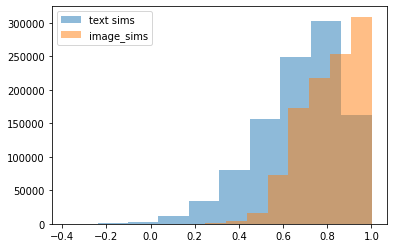

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist( (text_sims.cpu()).flatten().detach().cpu().numpy(), label='text sims', alpha=0.5)
plt.hist( (image_sims.cpu()).flatten().detach().cpu().numpy(), label='image_sims', alpha=0.5)
plt.legend()

In [ ]:
# Download the dataset
imagenet = ImageNet(root="/export/share/datasets/vision/imagenet", transform=preprocess, download=False, split='val')
loader = torch.utils.data.DataLoader(imagenet, batch_size=1024, num_workers=4)
text_inputs = torch.stack([tokenizer(f"a photo of a {c}") for c in imagenet.classes]).cuda()

num_correct = 0
num_seen = 0
with torch.no_grad():
    # text_features = model.encode_text(text_inputs)
    for imgs, targets in loader:
        imgs = imgs.cuda()
        targets = targets.cuda()
        
        # image_features = model.encode_image(imgs)
        results = model(imgs, text_inputs, lang_prompt_viz=True, sharded_computation=False)
        image_features = results['image_embed']
        text_features = results['text_embed']
        
        
        similarity = (image_features @ text_features.T).softmax(dim=-1)
        num_correct += (similarity.argmax(dim=-1)==targets).sum().item()  
        num_seen += imgs.shape[0]
        curr_acc = num_correct / num_seen
        print(f"Current Acc: {curr_acc}")
print(f"Final Acc {curr_acc}")

In [ ]:
# Download the dataset
raw_text_templates = [
        "itap of a {}.",
        "a bad photo of the {}.",
        "a origami {}.",
        "a photo of the large {}.",
        "a {} in a video game.",
        "art of the {}.",
        "a photo of the small {}."
    ]

raw_text_templates = [s.replace("{}", "{c}") for s in raw_text_templates]

tricky_text_templates = [f'f"{temp}"' for temp in raw_text_templates]
print(tricky_text_templates)

In [ ]:
all_text_inputs = []
for template in tricky_text_templates:
    all_text_inputs.append(torch.stack([tokenizer(eval(template)) for c in imagenet.classes]))

In [ ]:
imagenet = ImageNet(root="/export/share/datasets/vision/imagenet", transform=preprocess, download=False, split='val')
loader = torch.utils.data.DataLoader(imagenet, batch_size=1024, num_workers=4)
# text_inputs = torch.stack([tokenizer(f"a photo of a {c}") for c in imagenet.classes]).cuda()

num_correct = 0
num_seen = 0
with torch.no_grad():
    # text_features = model.encode_text(text_inputs)
    all_text_features = [model.encode_text(text_inputs.cuda())
                         for text_inputs in all_text_inputs]
    text_features = torch.stack(all_text_features).mean(dim=0)
    text_features = text_features / text_features.norm(dim=-1, keepdim=True)
    
    for imgs, targets in loader:
        imgs = imgs.cuda()
        targets = targets.cuda()
        image_features = model.encode_image(imgs)
        similarity = (image_features @ text_features.T).softmax(dim=-1)
        num_correct += (similarity.argmax(dim=-1)==targets).sum().item()  
        num_seen += imgs.shape[0]
        curr_acc = num_correct / num_seen
        print(f"Current Acc: {curr_acc}")
print(f"Final Acc {curr_acc}")

In [ ]:
coco_ds = CocoCaptions(root="/export/share/datasets/vision/coco/images/val2017/",
                             annFile="/export/share/datasets/vision/coco/annotations/captions_val2017.json",
                            transform=preprocess,
                            target_transform=random.choice)

loader = torch.utils.data.DataLoader(coco_ds, shuffle=False, batch_size=1024)

image_features = []
text_features = []
with torch.no_grad():
    for imgs, txts in loader:
        print(imgs.shape, txts.shape)
        imgs = imgs.to(device)
        txts = clip.tokenize(txts)
        txts = txts.to(device)
        image_features.append(model.encode_image(imgs))
        text_features.append(model.encode_text(txts))
    

image_features = torch.cat(image_features)
text_features = torch.cat(text_features)
print(image_features.shape, text_features.shape)

similarity = (image_features @ text_features.T).softmax(dim=-1)

targets = torch.arange(similarity.shape[0], device=device)

print(sum(similarity.argmax(dim=1)==targets) / len(targets))

print(sum(similarity.argmax(dim=0)==targets) / len(targets))

In [ ]:
coco_ds = CocoCaptions(root="/export/share/datasets/vision/coco/images/train2017/",
                             annFile="/export/share/datasets/vision/coco/annotations/captions_train2017.json",
                            transform=preprocess,
                            target_transform=random.choice)

loader = torch.utils.data.DataLoader(coco_ds, shuffle=False, batch_size=2048)

image_features = []
text_features = []
num_done = 0
with torch.no_grad():
    for imgs, txts in loader:
        imgs = imgs.to(device)
        txts = clip.tokenize(txts)
        txts = txts.to(device)
        image_features.append(model.encode_image(imgs))
        text_features.append(model.encode_text(txts))
        num_done += imgs.shape[0]
        print(num_done)
    

image_features = torch.cat(image_features)
text_features = torch.cat(text_features)
print(image_features.shape, text_features.shape)

similarity = (image_features @ text_features.T).softmax(dim=-1)

targets = torch.arange(similarity.shape[0], device=device)

print(sum(similarity.argmax(dim=1)==targets) / len(targets))

print(sum(similarity.argmax(dim=0)==targets) / len(targets))